In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
us_data = pickle.load(open( "us_data_final.p", "rb" ) )

In [13]:
us_data_mod = us_data[['Tolerance', 'Graduation Percentage']]
us_data_mod['Tol_Level'] = us_data_mod['Tolerance'].apply(lambda x: 'high' if x >= 7.29 else ('medium' if x >= 5.8 else 'low'))


In [14]:
scipy.stats.ttest_ind((us_data_mod[us_data_mod['Tol_Level'] == 'high']['Graduation Percentage']), (us_data_mod[us_data_mod['Tol_Level'] == 'low']['Graduation Percentage']))



Ttest_indResult(statistic=2.1040918135176074, pvalue=0.04170332061980797)

Beacause the test is statistically significant, we can go ahead and look at more granular data

In [398]:
df = pd.read_excel('lgbt_bullying/2016_2017_All_Respondent_Data/2016-2017Student.xlsx', header = [1,2,3], skiprows = 1)

orientation_bullying = df.iloc[:,[1,278,280,282,284,286]]
complete_homework = df.iloc[:,[1,368,370,372,374,376]]
safety = df.iloc[:,[1,418,420,422,424,426]]
combined = pd.merge(orientation_bullying, complete_homework)
combined = pd.merge(combined, safety)
columns_safe = ['Feel safe: Most or all of the time', 'Feel safe: Occasionally', 'Feel safe: Rarely', 'Feel safe: Never', 'Feel safe: Don\'t know']
columns_treated_badly = ['Treated Badly: Most or all of the time', 'Treated Badly: Occasionally', 'Treated Badly: Rarely', 'Treated Badly: Never', 'Treated Badly: Does not apply']
columns_complete_schoolwork = ['Complete Schoolwork: strongly agree', 'Complete Schoolwork: agree', 'Complete Schoolwork: disagree', 'Complete Schoolwork: strongly disagree', 'Complete Schoolwork: don\'t know']
combined.columns = ['School Name'] + columns_treated_badly + columns_complete_schoolwork + columns_safe

In [399]:
final_df = pd.DataFrame()
final_df['School_Name'] = combined.iloc[:,0]
final_df['Treated_Badly'] = combined.iloc[:,1] + combined.iloc[:,2] + combined.iloc[:,3]
final_df['Not_Treated_Badly'] = combined.iloc[:,4] + combined.iloc[:,5]
final_df['Completes_Schoolwork'] = combined.iloc[:,6] + combined.iloc[:,7]
final_df['Does_Not_Complete_Schoolwork'] = combined.iloc[:,8] + combined.iloc[:,9] + combined.iloc[:,10]
final_df['Feels_Safe'] = combined.iloc[:,11]
final_df['Does_Not_Feel_Safe'] = combined.iloc[:,12] + combined.iloc[:,13]
final_df = final_df[final_df['Treated_Badly'] < .2]
final_df.set_index('School_Name', inplace = True)

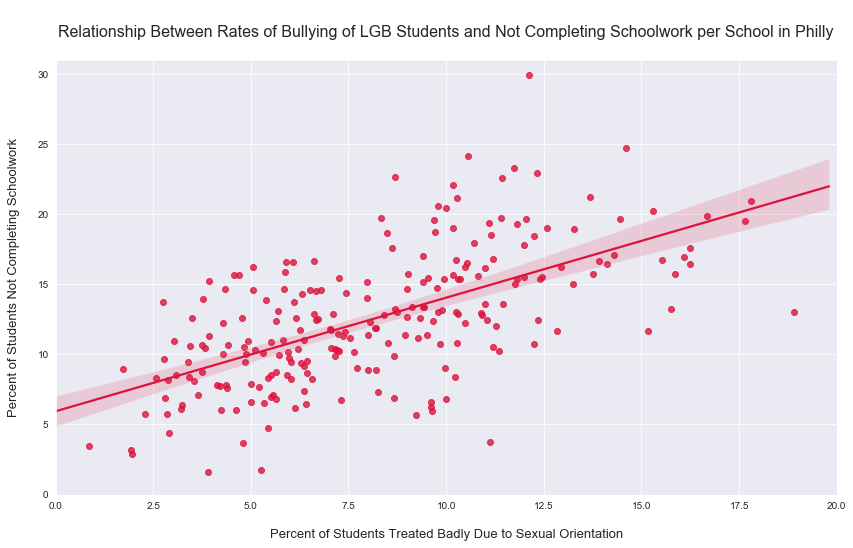

In [400]:
plt.figure(figsize = (14,8))
sns.regplot(x = final_df['Treated_Badly']*100, y = final_df['Does_Not_Complete_Schoolwork']*100, color = 'crimson')
plt.xlabel("\nPercent of Students Treated Badly Due to Sexual Orientation", fontsize = 13)
plt.ylabel("Percent of Students Not Completing Schoolwork\n", fontsize = 13)
plt.title('\nRelationship Between Rates of Bullying of LGB Students and Not Completing Schoolwork per School in Philly\n', fontsize = 16)
plt.xlim(0,.2*100)
plt.ylim(0,.31*100)
plt.savefig('NotDoingSchoolwork_LGB.png')
plt.show()

In [401]:
mod = ols('Does_Not_Complete_Schoolwork ~ Treated_Badly*Does_Not_Feel_Safe', data=final_df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                                        sum_sq     df          F        PR(>F)
Treated_Badly                     1.280245e-01    1.0  96.053825  3.564921e-19
Does_Not_Feel_Safe                1.550047e-02    1.0  11.629638  7.665051e-04
Treated_Badly:Does_Not_Feel_Safe  5.375094e-07    1.0   0.000403  9.839955e-01
Residual                          3.065536e-01  230.0        NaN           NaN


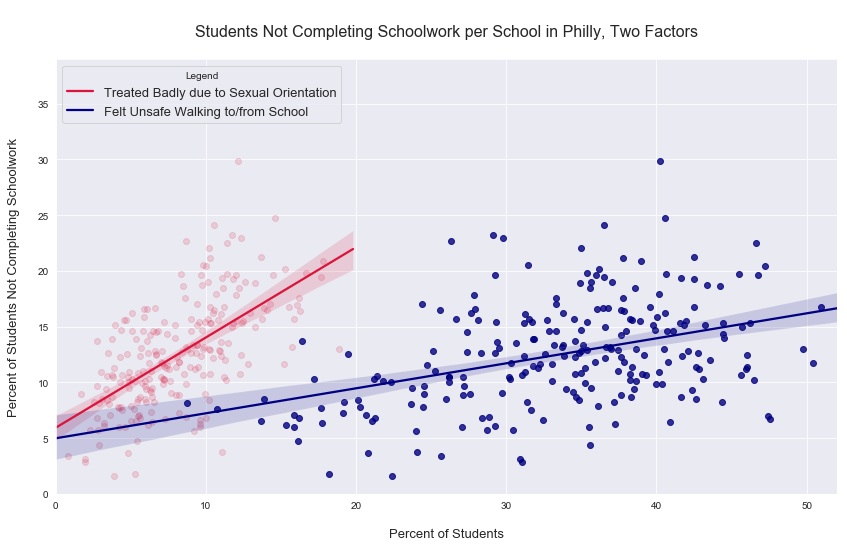

In [402]:
plt.figure(figsize = (14,8))
sns.regplot(x = final_df['Treated_Badly']*100, y = final_df['Does_Not_Complete_Schoolwork']*100, color = 'crimson', scatter_kws={'alpha':0.15})
sns.regplot(x = final_df['Does_Not_Feel_Safe']*100, y = final_df['Does_Not_Complete_Schoolwork']*100, color = 'navy')

plt.xlabel("\nPercent of Students", fontsize = 13)
plt.ylabel("Percent of Students Not Completing Schoolwork\n", fontsize = 13)
plt.title('\nStudents Not Completing Schoolwork per School in Philly, Two Factors\n', fontsize = 16)
plt.legend(title = 'Legend', loc = 'upper left', labels = ['Treated Badly due to Sexual Orientation', 'Felt Unsafe Walking to/from School'], fontsize = 13)
plt.xlim(0,.52*100)
plt.ylim(0,.39*100)
plt.savefig('NotDoingSchoolwork_LGB_Safe.png')
plt.show()